# 20.2 Accuracy After Model Selection

### Setup

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
cholesterol = pd.read_csv("../data/cholesterol.txt", delimiter=" ")
cholesterol.head()

,compliance,cholesterol.decrease
0,-2.2510,11.50
1,-2.2510,-6.25
2,-2.2510,-7.25
3,-2.2510,-5.25
4,-1.8312,-23.00


### Calculate C<sub>p</sub> for polynomial models

In [4]:
# https://stackoverflow.com/a/41317397 for the orthogonal polynomial

def make_poly(x, degree, orthogonal=False):
    x_mat = np.transpose(np.vstack((x**k for k in range(degree + 1))))
    if orthogonal:
        x_mat = np.linalg.qr(x_mat)[0]
        x_mat[:, 0] = 1
    columns = ["x{}".format(i) for i in range(degree + 1)]
    return pd.DataFrame(x_mat, columns=columns)

Note the Cp function below does not divide by the number of observations, unlike in equation 12.51

In [5]:
def cp(results, X, y, sigma_hat):
    nobs, p = X.shape
    resid = results.predict(X) - y
    err = (resid**2).sum()
    covariance_penalty = 2 * p * sigma_hat**2
    return err + covariance_penalty

In [6]:
y = cholesterol["cholesterol.decrease"]

cp_vals = []
for degree in range(7):
    X = make_poly(cholesterol["compliance"], degree=degree)
    model = sm.OLS(y, X)
    res = model.fit()
    cp_val = cp(res, X, y, sigma_hat=22.0)
    cp_vals.append(cp_val)

### Table 20.2

In [7]:
tmplt = "   {}   {:8.0f}"
print(" Degree     Cp")
print("----------------")
for degree, cp_val in enumerate(cp_vals):
    print(tmplt.format(degree, cp_val - 80000))

 Degree     Cp
----------------
   0      71887
   1       1131
   2       1411
   3        667
   4       1591
   5       1811
   6       2758


### Bootstrap samples, adaptive degree

The function below carries out the C<sub>p</sub>-based procedure for choosing the polynomial degree and fitting the chosen model

In [8]:
def find_poly_fit(x, y):
    cp_vals = []
    for degree in range(7):
        X = make_poly(x, degree=degree)
        res = sm.OLS(y, X).fit()
        cp_val = cp(res, X, y, sigma_hat=22.0)
        cp_vals.append(cp_val)
    best_degree = np.argmin(cp_vals)
    X = make_poly(x, degree=best_degree)
    return sm.OLS(y, X).fit(), best_degree

We have to record extra details here. For Figure 20.5 we need to record the number of times each datapoint is selected for each bootstrap sample (and put extra work into calculating the bagged standard errors). For Figure 20.6 we need to record the degree of the polynomial chosen for each bootstrap model.

In [9]:
n_boots = 4000
n_obs = cholesterol.shape[0]

indices = np.arange(n_obs)
bootstrap_indices = np.zeros((n_boots, n_obs))

for i in range(n_boots):
    bootstrap_indices[i, :] = np.random.choice(indices, size=n_obs, replace=True)

In [10]:
x_pred = np.arange(-2.2, 2.0, 0.05)
y_pred_adapt = np.zeros((n_boots, x_pred.shape[0]))
degree_adapt = np.zeros(n_boots, dtype="int")

for i in range(n_boots):
    data = cholesterol.iloc[bootstrap_indices[i, :]]
    y = data["cholesterol.decrease"].values
    x = data["compliance"].values
    res, degree = find_poly_fit(x, y)
    y_pred_adapt[i, :] = res.predict(make_poly(x_pred, degree))
    degree_adapt[i] = degree

In [11]:
se_adapt = np.sqrt(y_pred_adapt[:, 4].var(ddof=1))
print("s.e. at -2: {:.2f}".format(se_adapt))

s.e. at -2: 7.88


This s.e. is usually quite different from the book's value, 5.98

Calculate s.e. of the bagged estimate, (20.29) - (20.32)

In [12]:
# N from (20.29)
n_mat = np.zeros((n_boots, n_obs))
for i in range(n_obs):
    n_mat[:, i] = (bootstrap_indices == i).sum(axis=1)

In [13]:
# eq (20.31) and (20.32)

def cov_j(n_mat, t_mat, t_index, j):
    return (
        (n_mat[:, j] - n_mat[:, j].mean()) * 
        (t_mat[:, t_index] - t_mat[:, t_index].mean())
    ).mean(axis=0)

def se_tindex(n_mat, t_mat, t_index):
    cov_sq = [cov_j(n_mat, t_mat, t_index, j)**2 for j in range(n_obs)]
    return np.sqrt(np.sum(cov_sq))

def se_bagged(n_mat, t_mat):
    return np.array([se_tindex(n_mat, t_mat, i) for i in range(t_mat.shape[1])])

In [14]:
ses_bagged = se_bagged(n_mat, y_pred_adapt)

Check that `ses_bagged` has the right shape

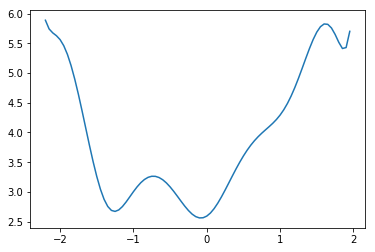

In [15]:
plt.plot(x_pred, ses_bagged);

### Bootstrap samples, degree fixed at 3

In [16]:
n_boots = 4000
n_obs = cholesterol.shape[0]

x_pred = make_poly(np.arange(-2.2, 2.0, 0.05), degree=3,)
y_pred_fixed = np.zeros((n_boots, x_pred.shape[0]))

for i in range(n_boots):
    data = cholesterol.sample(n_obs, replace=True)
    y = data["cholesterol.decrease"].values
    X = make_poly(data["compliance"], degree=3)
    res = sm.OLS(y, X).fit()
    y_pred_fixed[i, :] = res.predict(x_pred)

In [17]:
se_fixed = np.sqrt(y_pred_fixed[:, 4].var(ddof=1))
print("s.e. at -2: {:.2f}".format(se_fixed))

s.e. at -2: 4.13


This s.e. is usually similar to the book's value, 3.97

### Figure 20.4

In [18]:
adapt_neg2 = y_pred_adapt[:, 4]
fixed_neg2 = y_pred_fixed[:, 4]

bins = np.arange(-21, 25, 0.9)

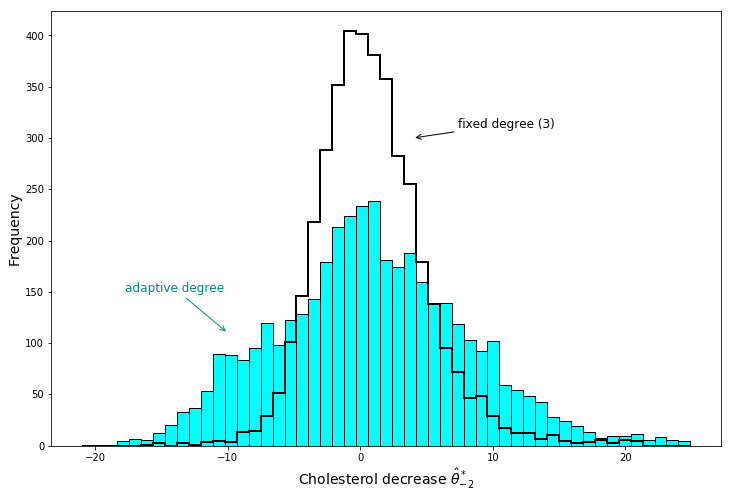

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(adapt_neg2, bins=bins, color="cyan", edgecolor="k")
ax.hist(fixed_neg2, bins=bins, histtype="step", edgecolor="k", linewidth=2)

ax.annotate(
    "adaptive degree",
    size=12,
    xy=(-10, 110),
    xytext=(-14, 150),
    arrowprops=dict(
        arrowstyle="->",
        color="darkcyan",
    ),
    color="darkcyan",
    horizontalalignment="center",
)

ax.annotate(
    "fixed degree (3)",
    size=12,
    xy=(4, 300),
    xytext=(11, 310),
    arrowprops=dict(
        arrowstyle="->",
        color="k",
    ),
    color="k",
    horizontalalignment="center",
)

ax.set_xlabel("Cholesterol decrease $\\hat{\\theta}_{-2}^*$", size=14)
ax.set_ylabel("Frequency", size=14);

For the plot above, I limited the bins to give a picture similar to the book's. Without the limit, the picture looks a lot different:

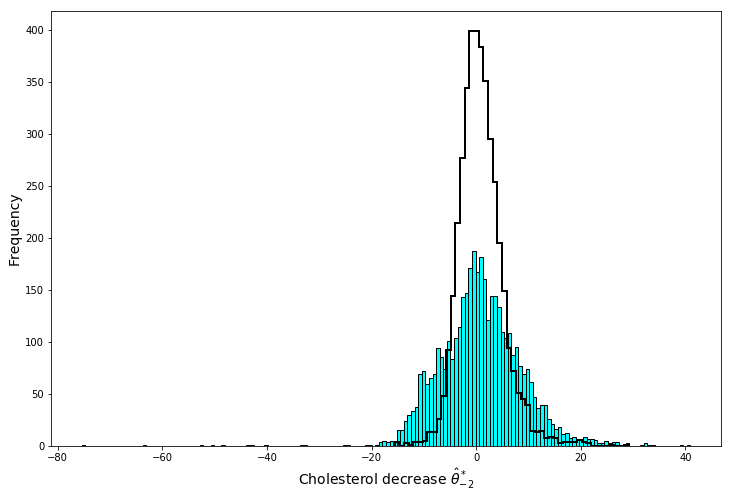

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(adapt_neg2, bins=170, color="cyan", edgecolor="k")
ax.hist(fixed_neg2, bins=50, histtype="step", edgecolor="k", linewidth=2)

ax.set_xlabel("Cholesterol decrease $\\hat{\\theta}_{-2}^*$", size=14)
ax.set_ylabel("Frequency", size=14);

### Figure 20.5

In [21]:
ses_adapt = np.sqrt(y_pred_adapt.var(ddof=1, axis=0))
ses_fixed = np.sqrt(y_pred_fixed.var(ddof=1, axis=0))

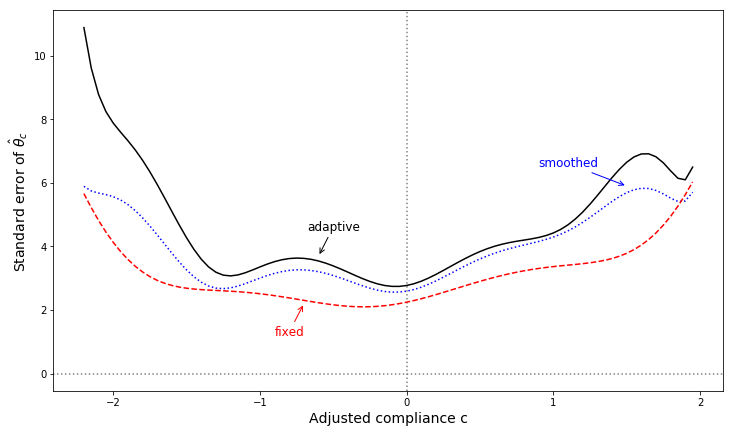

In [22]:
fig, ax = plt.subplots(figsize=(12, 7))

xvals = np.arange(-2.2, 2.0, 0.05)

ax.axhline(0, c="gray", linestyle=":")
ax.axvline(0, c="gray", linestyle=":")

ax.plot(xvals, ses_adapt, c="k")
ax.plot(xvals, ses_bagged, c="b", linestyle=":")
ax.plot(xvals, ses_fixed, c="r", linestyle="--")

ax.annotate(
    "adaptive",
    size=12,
    xy=(-0.6, 3.7),
    xytext=(-0.5, 4.5),
    arrowprops=dict(
        arrowstyle="->",
        color="k",
    ),
    color="k",
    horizontalalignment="center",
)

ax.annotate(
    "fixed",
    size=12,
    xy=(-0.7, 2.2),
    xytext=(-0.8, 1.2),
    arrowprops=dict(
        arrowstyle="->",
        color="r",
    ),
    color="r",
    horizontalalignment="center",
)

ax.annotate(
    "smoothed",
    size=12,
    xy=(1.5, 5.9),
    xytext=(1.1, 6.5),
    arrowprops=dict(
        arrowstyle="->",
        color="b",
    ),
    color="b",
    horizontalalignment="center",
)

ax.set_xlabel("Adjusted compliance c", size=14)
ax.set_ylabel("Standard error of $\\hat{\\theta}_c$", size=14);

Check that we get, roughly, "the ratio of $\hat{\text{se}}_\text{IJ}[s_c({\bf x})] / \hat{\text{se}}_\text{boot}[t(c, {\bf x})]$ averaging 0.88" and and "adaptive/fixed D 1.43, adaptive/smoothed D 1.14"

In [23]:
(ses_bagged / ses_adapt).mean().round(2)

0.87

In [24]:
(ses_adapt / ses_fixed).mean().round(2)

1.48

In [25]:
(ses_adapt / ses_bagged).mean().round(2)

1.16

### Figure 20.6

"Histograms are scaled to have equal areas"

In [26]:
freq_1, edges = np.histogram(adapt_neg2[degree_adapt == 1], bins=bins)
freq_2, _ = np.histogram(fixed_neg2, bins=bins)
freq_3, _ = np.histogram(adapt_neg2[degree_adapt != 1], bins=bins)

area_1 = ((edges[1:] - edges[:-1]) * freq_1).sum()
area_2 = ((edges[1:] - edges[:-1]) * freq_2).sum()
area_3 = ((edges[1:] - edges[:-1]) * freq_3).sum()

centers = (edges[:-1] + edges[1:]) / 2

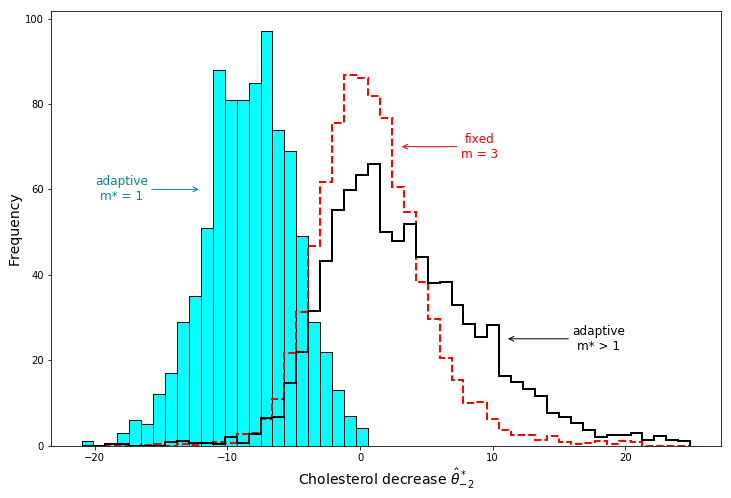

In [27]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.hist(adapt_neg2[degree_adapt == 1], bins=bins, color="cyan", edgecolor="k")
ax.hist(
    fixed_neg2,
    bins=bins,
    histtype="step",
    edgecolor="r",
    linewidth=2,
    linestyle="--",
    weights=[(area_1 / area_2)] * fixed_neg2.shape[0],
)
ax.hist(
    adapt_neg2[degree_adapt != 1],
    bins=bins,
    histtype="step",
    edgecolor="k",
    linewidth=2,
    weights=[(area_1 / area_3)] * adapt_neg2[degree_adapt != 1].shape[0]
)

ax.annotate(
    "adaptive\nm* = 1",
    size=12,
    xy=(-12, 60),
    xytext=(-18, 60),
    arrowprops=dict(
        arrowstyle="->",
        color="darkcyan",
    ),
    color="darkcyan",
    horizontalalignment="center",
    verticalalignment="center",
)

ax.annotate(
    "fixed\nm = 3",
    size=12,
    xy=(3, 70),
    xytext=(9, 70),
    arrowprops=dict(
        arrowstyle="->",
        color="r",
    ),
    color="r",
    horizontalalignment="center",
    verticalalignment="center",
)

ax.annotate(
    "adaptive\nm* > 1",
    size=12,
    xy=(11, 25),
    xytext=(18, 25),
    arrowprops=dict(
        arrowstyle="->",
        color="k",
    ),
    color="k",
    horizontalalignment="center",
    verticalalignment="center",
)

ax.set_xlabel("Cholesterol decrease $\\hat{\\theta}_{-2}^*$", size=14)
ax.set_ylabel("Frequency", size=14);

### Table 20.3

In [28]:
degree_dummy = np.zeros((n_boots, 7))
degree_dummy[np.arange(n_boots), degree_adapt.astype("int")] = 1

In [29]:
se_props = se_bagged(n_mat, degree_dummy)

In [30]:
proportions = [(degree_adapt == i).sum() / 4000 for i in range(1, 7)]
print("            m =    1     2     3     4     5     6")
print("---------------------------------------------------")
print(" proportion     {:.2f}  {:.2f}  {:.2f}  {:.2f}  {:.2f}  {:.2f}".format(*proportions))
print("    sd_IJ       {:.2f}  {:.2f}  {:.2f}  {:.2f}  {:.2f}  {:.2f}".format(*se_props[1:]))

            m =    1     2     3     4     5     6
---------------------------------------------------
 proportion     0.21  0.13  0.34  0.08  0.19  0.05
    sd_IJ       0.26  0.19  0.25  0.15  0.26  0.05
